# Forecasting customer churn

## Project Description.
The telecom operator 'Telecom' wants to learn how to predict customer churn. If it turns out that the user is planning to leave, they will be offered promo codes and special terms. The operator's team has collected personal data on some customers, information about their tariffs and contracts.

**Objective:** Build a model to predict customer churn for a company providing Internet and telephony services.

The metric auc_roc must be higher than 85%

### Description of services

**Main:**
1. Fixed telephone service. Possibility to connect the phone to multiple lines simultaneously.
2. internet. There are two types of connection: via telephone line (DSL*,**digital subscriber line*) or fiber optic cable (*Fiber optic*).  

**Additional:**
- internet security: anti-virus (*DeviceProtection*) and blocking of unsafe sites (*OnlineSecurity*);
- dedicated technical support line (*TechSupport*);
- cloud file storage for data backup (*OnlineBackup*);
- streaming TV (*StreamingTV*) and movie catalog (*StreamingMovies*).

### Description of the data

**The data consists of files obtained from different sources:**

- `contract_new.csv` - information about the contract
 - customerID - customer's unique number
 - BeginDate - date when the client started using the service
 - EndDate - date when the service usage ends
 - Type - payment type: monthly, yearly, etc.
 - PaperlessBilling - electronic payment document
 - PaymentMethod - payment method
 - MonthlyCharges - monthly expenses for the services
 - TotalCharges - total money spent for the services
 
 
- `personal_new.csv` - client's personal data
  - customerID - customer's unique number
  - gender - gender of client
  - Dependents - existence of dependents
  - Senior Citizen - customer's senior citizen status
  - Partner - customer's spouse
  
  
- `internet_new.csv` - information on Internet services
   - customerID - customer's unique number
   - InternetService - types of connection: via telephone line (DSL) or fiber optic cable (Fiber optic)
   - DeviceProtection - antivirus
   - OnlineSecurity - blocking access to unsafe sites
   - TechSupport - Dedicated technical support line
   - OnlineBackup - cloud file storage for data backup
   - StreamingTV - streaming TV
   - StreamingMovies - movie catalog
   
   
- `phone_new.csv` - information about the telephone services
    - customerID - unique number of client
    - MultipleLines - the ability to maintain multiple lines during the call

Information about contracts is current as of February 1, 2020.

# Exploratory data analysis

## Data preprocessing

Import pandas, numpy, seaborn, and sklearn libraries for further work:

In [1]:
!pip install phik
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from phik import phik_matrix

RANDOM_STATE = 120623

In [2]:
try:
    data_contract = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\contract_new.csv')
    data_personal = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\personal_new.csv')
    data_internet = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\internet_new.csv')
    data_phone = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\phone_new.csv')
except:
    data_contract = pd.read_csv('/datasets/contract_new.csv')
    data_personal = pd.read_csv('/datasets/personal_new.csv')
    data_internet = pd.read_csv('/datasets/internet_new.csv')
    data_phone = pd.read_csv('/datasets/phone_new.csv')

Let's write a function `show()`, use it to check the data of each dataframe for duplicates, missing values, display general information of the dataframe, the size of the table and see the first 5 lines using the method `head()`.

### data_contract:

In [3]:
def show (data):
    print('Duplicates:', data.duplicated().sum(), '\n')
    print('Missing_values:\n', data.isna().sum(), '\n')
    print('Table size:', data.shape, '\n')
    data.info()
    return data.head()
show(data_contract)

Duplicates: 0 

Missing_values:
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64 

Table size: (7043, 8) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


No duplicates or missing values are found in the data. Let's check the data for implicit omissions, look at the contents of the columns and change the data types to the correct ones:

Let's start with the `BeginDate` column and change the data type from 'object' to 'datetime':

In [4]:
data_contract['BeginDate'] =  data_contract['BeginDate'].apply(pd.to_datetime)

Now let's look at the contents of the `EndDate` column:

In [5]:
data_contract['EndDate'].sort_values().value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-11-01       1
2014-10-01       1
2014-06-01       1
Name: EndDate, Length: 67, dtype: int64

The value 'No' says that at the time of the data upload client was active and did not terminate the contract, with 'sort_value' you can see that the maximum date of the contract is January 01, 2020, so you can replace the values `No` to `20-02-01` and bring the feature to the data type 'datetime':

In [6]:
data_contract['EndDate'] = data_contract['EndDate'].replace('No','2020-02-01')
data_contract['EndDate'] =  data_contract['EndDate'].apply(pd.to_datetime)
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


Check the unique values of columns `Type`, `PaymentMethod`, `PaperlessBilling`:

In [7]:
print('Unique values of Type: ', data_contract['Type'].unique())
print('Unique values of PaymentMethod: ', data_contract['PaymentMethod'].unique())
print('Unique values of PaperlessBilling: ', data_contract['PaperlessBilling'].unique())

Unique values of Type:  ['Month-to-month' 'One year' 'Two year']
Unique values of PaymentMethod:  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Unique values of PaperlessBilling:  ['Yes' 'No']


The values of these features look correct

Check the unique values in the `MonthlyCharges` and `TotalCharges` columns by sorting them in ascending order, so we can additionally see the minimum and maximum values:

In [8]:
print('Unique values of MonthlyCharges: ', data_contract['MonthlyCharges'].sort_values().unique())
print('Unique values of TotalCharges: ', data_contract['TotalCharges'].sort_values().unique())

Unique values of MonthlyCharges:  [ 18.25  18.4   18.55 ... 118.6  118.65 118.75]
Unique values of TotalCharges:  [' ' '100.17' '100.19' ... '998.89' '999.6' '999.9']


The values of the feature `MonthlyCharges` look correct, but in `TotalCharges` there are gaps, let's display them:

In [9]:
print('Share of missing values TotalCharges:', round(len(data_contract[data_contract['TotalCharges'] == ' '])/
                                                len(data_contract['TotalCharges']),4)*100, '%')
data_contract[data_contract['TotalCharges'] == ' ']

Share of missing values TotalCharges: 0.16 %


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,


According to the data you can see that the missing values in the `TotalCharges` refer to users connected to the tariff on the day of the database upload (2020-02-01), such values are too small (less than 1%) and they will not affect the result, let's remove them from the sample, and replace the data type 'object' to 'float':

In [10]:
data_contract = data_contract.loc[data_contract['TotalCharges'] != ' ']
data_contract['TotalCharges'] = data_contract['TotalCharges'].astype('float64')
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 494.4+ KB


The target feature is the client leaving the company, let's allocate it to a separate column `left_the_company`, where the value '0' - the client of the company, '1' - the client who left the company:

In [11]:
data_contract.loc[data_contract['EndDate'] == '2020-02-01', 'left_the_company'] = 0
data_contract.loc[data_contract['EndDate'] != '2020-02-01', 'left_the_company'] = 1

Create a feature `days_at_company`, which shows how long the client is in the company (we need it for further analysis)

In [12]:
data_contract['days_at_company'] = (data_contract['EndDate'] - data_contract['BeginDate']).dt.days
data_contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,left_the_company,days_at_company
2021,0181-RITDD,2014-12-01,2020-02-01,Two year,No,Mailed check,108.15,6772.35,0.0,1888
5859,2194-IIQOF,2014-03-01,2020-02-01,Two year,No,Credit card (automatic),89.30,6340.30,0.0,2163
3911,0991-BRRFB,2018-06-01,2020-02-01,Month-to-month,No,Electronic check,49.40,988.00,0.0,610
1528,8096-LOIST,2018-07-01,2020-02-01,Month-to-month,Yes,Electronic check,56.20,1153.22,0.0,580
1544,3794-NFNCH,2017-08-01,2020-02-01,Month-to-month,Yes,Mailed check,50.00,1560.00,0.0,914


The names of the features do not look correct and make it hard to read, so let's convert them to 'snake_case':

In [13]:
data_contract.rename(columns={'customerID': 'customer_id'}, inplace=True)
data_contract.rename(columns={'BeginDate': 'begin_date'}, inplace=True)
data_contract.rename(columns={'EndDate': 'end_date'}, inplace=True)
data_contract.rename(columns={'Type': 'type'}, inplace=True)
data_contract.rename(columns={'PaperlessBilling': 'paperless_billing'}, inplace=True)
data_contract.rename(columns={'PaymentMethod': 'payment_method'}, inplace=True)
data_contract.rename(columns={'MonthlyCharges': 'monthly_charges'}, inplace=True)
data_contract.rename(columns={'TotalCharges': 'total_charges'}, inplace=True)

data_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   left_the_company   7032 non-null   float64       
 9   days_at_company    7032 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 604.3+ KB


The 'data_contract' data is preprocessed, let's move on to the next sample.

### data_personal:

In [14]:
show(data_personal)

Duplicates: 0 

Missing_values:
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64 

Table size: (7043, 5) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


This table looks without obvious errors, there are no duplicates, change only the data type of feature `SeniorCitizen` and replace '1' and '0' with 'Yes' and 'No' (because it is not numeric, but tells us whether the client is retired or not), check unique values and bring the column names to 'snake_case':

In [15]:
data_personal['SeniorCitizen'] = data_personal['SeniorCitizen'].replace(0, 'No')
data_personal['SeniorCitizen'] = data_personal['SeniorCitizen'].replace(1, 'Yes')
data_personal['SeniorCitizen'] = data_personal['SeniorCitizen'].astype('object')


print('Unique values of gender: ', data_personal['gender'].unique())
print('Unique values of SeniorCitizen: ', data_personal['SeniorCitizen'].unique())
print('Unique values of Partner: ', data_personal['Partner'].unique())
print('Unique values of Dependents: ', data_personal['Dependents'].unique())

Unique values of gender:  ['Female' 'Male']
Unique values of SeniorCitizen:  ['No' 'Yes']
Unique values of Partner:  ['Yes' 'No']
Unique values of Dependents:  ['No' 'Yes']


In [16]:
data_personal.rename(columns={'customerID': 'customer_id'}, inplace=True)
data_personal.rename(columns={'SeniorCitizen': 'senior_citizen'}, inplace=True)
data_personal.rename(columns={'Partner': 'partner'}, inplace=True)
data_personal.rename(columns={'Dependents': 'dependents'}, inplace=True)
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


The 'data_personal' data is preprocessed, let's move on to the next sample.

### data_internet:

In [17]:
show(data_internet)

Duplicates: 0 

Missing_values:
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64 

Table size: (5517, 8) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


This table looks without obvious errors, no duplicates, data types are correct, check unique values and bring column names to 'snake_case':

In [18]:
print('Unique values of InternetService: ', data_internet['InternetService'].unique())
print('Unique values of OnlineSecurity: ', data_internet['OnlineSecurity'].unique())
print('Unique values of OnlineBackup: ', data_internet['OnlineBackup'].unique())
print('Unique values of DeviceProtection: ', data_internet['DeviceProtection'].unique())
print('Unique values of TechSupport: ', data_internet['TechSupport'].unique())
print('Unique values of StreamingTV: ', data_internet['StreamingTV'].unique())
print('Unique values of StreamingMovies: ', data_internet['StreamingMovies'].unique())

Unique values of InternetService:  ['DSL' 'Fiber optic']
Unique values of OnlineSecurity:  ['No' 'Yes']
Unique values of OnlineBackup:  ['Yes' 'No']
Unique values of DeviceProtection:  ['No' 'Yes']
Unique values of TechSupport:  ['No' 'Yes']
Unique values of StreamingTV:  ['No' 'Yes']
Unique values of StreamingMovies:  ['No' 'Yes']


In [19]:
data_internet.rename(columns={'customerID': 'customer_id'}, inplace=True)
data_internet.rename(columns={'InternetService': 'internet_service'}, inplace=True)
data_internet.rename(columns={'OnlineSecurity': 'online_security'}, inplace=True)
data_internet.rename(columns={'OnlineBackup': 'online_backup'}, inplace=True)
data_internet.rename(columns={'DeviceProtection': 'device_protection'}, inplace=True)
data_internet.rename(columns={'TechSupport': 'tech_support'}, inplace=True)
data_internet.rename(columns={'StreamingTV': 'streaming_tv'}, inplace=True)
data_internet.rename(columns={'StreamingMovies': 'streaming_movies'}, inplace=True)
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


The 'data_internet' data is preprocessed, let's move on to the next sample.

### data_phone:

In [20]:
show(data_phone)

Duplicates: 0 

Missing_values:
 customerID       0
MultipleLines    0
dtype: int64 

Table size: (6361, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


This table looks without obvious errors, no duplicates, data types are correct, check unique values and bring column names to 'snake_case':

In [21]:
print('Unique values of MultipleLines: ', data_phone['MultipleLines'].unique())

Unique values of MultipleLines:  ['No' 'Yes']


In [22]:
data_phone.rename(columns={'customerID': 'customer_id'}, inplace=True)
data_phone.rename(columns={'MultipleLines': 'multiple_lines'}, inplace=True)
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Let's merge all samples into a single dataframe. When merging the tables, instead of empty feature values we will specify `No`, and display the last 5 rows of the merged dataframe:

In [23]:
data = data_contract.merge(data_personal, on='customer_id', how='left').merge(data_internet, on='customer_id',how='left')\
.merge(data_phone, on='customer_id', how='left').fillna('No')
data.set_index('customer_id', inplace=True)
data.tail()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,left_the_company,days_at_company,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,,,
6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,2035.20,0.0,730,Male,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7430.40,0.0,2191,Female,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,325.60,0.0,337,Female,...,Yes,Yes,DSL,Yes,No,No,No,No,No,No
8361-LTMKD,2019-07-01,2020-02-01,Month-to-month,Yes,Mailed check,74.40,520.80,0.0,215,Male,...,Yes,No,Fiber optic,No,No,No,No,No,No,Yes
3186-AJIEK,2014-08-01,2020-02-01,Two year,Yes,Bank transfer (automatic),105.65,7251.82,0.0,2010,Male,...,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No


We preprocessed the data: checked for explicit and implicit duplicates, got rid of missing values, reduced column names of all dataframes to 'snake_case', changed data types to correct values, and merged all dataframes into one. Let's move on to data analysis.

## Data analysis

Let's start with the distribution of the target feature `left_the_company`:

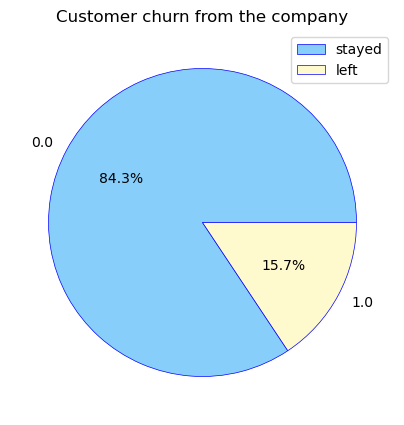

In [24]:
data['left_the_company'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5),
                                             colors=['#87CEFA', '#FFFACD'],
                                             wedgeprops={'edgecolor': 'blue', 'linewidth': 0.5})
plt.legend(['stayed', 'left'])
plt.title('Customer churn from the company')
plt.axis('off');

The diagram shows that 15.7% of clients left the company, there is an imbalance of classes

Let's unload the graphs of numerical features and look at the correlation matrix with which feature is most associated with the departure of the client:

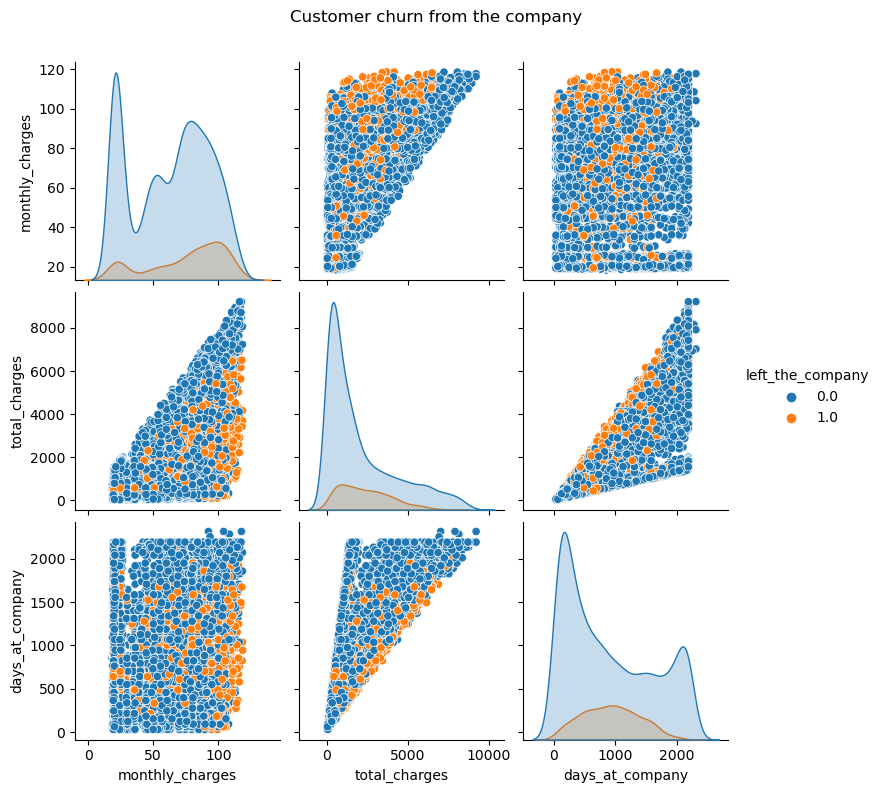

In [25]:
sns.pairplot(data, hue='left_the_company').fig.suptitle('Customer churn from the company', y=1.05);

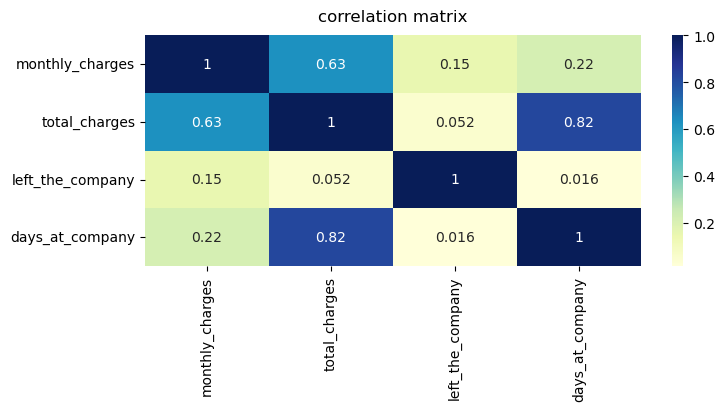

In [26]:
plt.figure(figsize=(8,3))
ax = plt.subplot()
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu", fmt ='.2g')
ax.set_title('correlation matrix', y=1.025);

The graphs clearly show that the client leaving the company is most dependent on the monthly payment, and the features `total_charges` and `days_at_company` are highly correlated with each other, which is logical - the more days, the higher the total payment amount. Let's take a closer look at the monthly payments, total payments, and time in the company of the remaining clients and those who left the company:

In [27]:
data.groupby('left_the_company').agg({'total_charges' : ['min', 'max', 'mean','median'],
                                      'monthly_charges' : ['min', 'max', 'mean','median'],
                                      'days_at_company' : ['min', 'max', 'mean','median']})

total_charges                                monthly_charges  \
                           min      max         mean   median             min   
left_the_company                                                                
0.0                      19.05  9221.38  2071.701614  1194.28           18.25   
1.0                      77.84  7649.76  2371.377275  2139.03           18.40   

                                           days_at_company                   \
                     max       mean median             min   max       mean   
left_the_company                                                              
0.0               118.60  62.803043  69.25              31  2314  895.33856   
1.0               118.75  75.546004  84.20              28  2129  924.86376   

                         
                 median  
left_the_company         
0.0               702.0  
1.0               915.0

On average, the clients who left spent more per month (median 84.2), the amount of payments of the clients who left on average significantly exceeds the amount of the remaining clients (median 2139), and also the minimum amount of payments of the users who left exceeds the amount of the remaining users by 3 times. From this table we can conclude that the users who left spent more than those who stayed. According to the length of time the clients who left the company were the clients of the company longer (median 915 days). Let's look in detail at how customers used Internet services. First, let's look at the use of services by customers who left the company:

In [28]:
data_left = data[data['left_the_company'] == 1]
data_stay = data[data['left_the_company'] == 0]

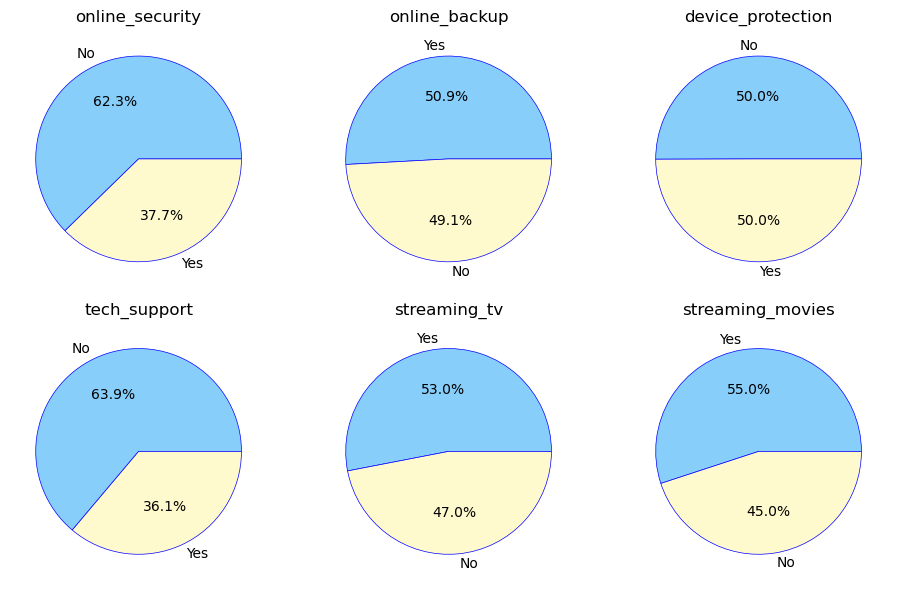

In [29]:
def visual_pie(df, column, index_x, index_y):
    df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[index_x, index_y],
                                   colors=['#87CEFA', '#FFFACD', 'lightgray'],
                                   wedgeprops={'edgecolor': 'blue', 'linewidth': 0.5})
    axes[index_x,index_y].set_title(column)
    axes[index_x,index_y].axis('off')
    plt.tight_layout()
    
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

visual_pie(data_left, 'online_security', 0, 0)
visual_pie(data_left, 'online_backup', 0, 1)
visual_pie(data_left, 'device_protection', 0, 2)
visual_pie(data_left, 'tech_support', 1, 0)
visual_pie(data_left, 'streaming_tv', 1, 1)
visual_pie(data_left, 'streaming_movies', 1, 2)

We see that half of the users who left were connected to additional Internet services, which explains the higher monthly payments and total payments. Now let's see if the clients who stayed with the company use these services:

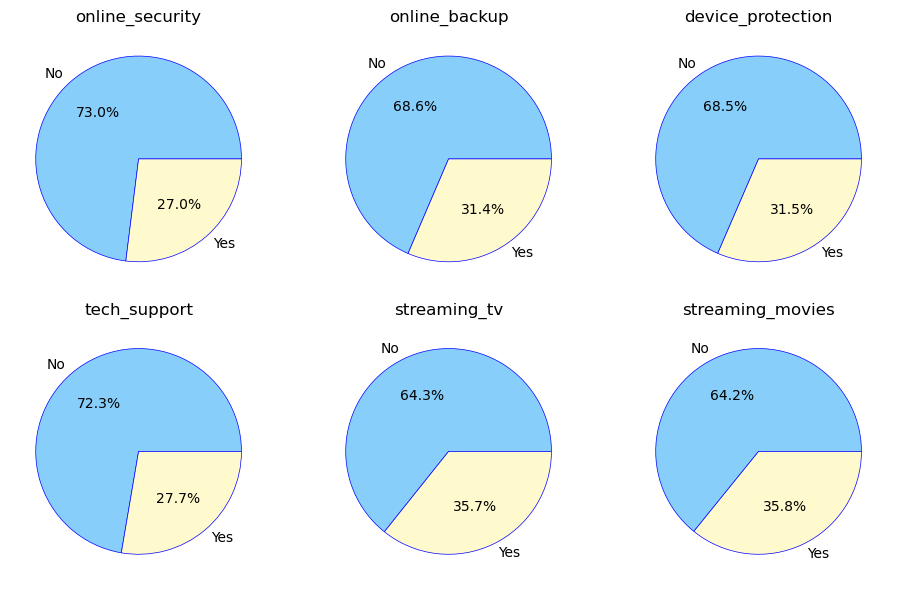

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

visual_pie(data_stay, 'online_security', 0, 0)
visual_pie(data_stay, 'online_backup', 0, 1)
visual_pie(data_stay, 'device_protection', 0, 2)
visual_pie(data_stay, 'tech_support', 1, 0)
visual_pie(data_stay, 'streaming_tv', 1, 1)
visual_pie(data_stay, 'streaming_movies', 1, 2)

We see that most of the remaining customers do not use additional Internet services, also the feature `straming_tv` and `stremaing_movies` have almost the same ratio both among those who left and those who stayed, probably these two services are connected with each other, for example by subscription. Let's compare the use of multichannel communication between the clients who left and those who stayed, as well as their types of contracts:

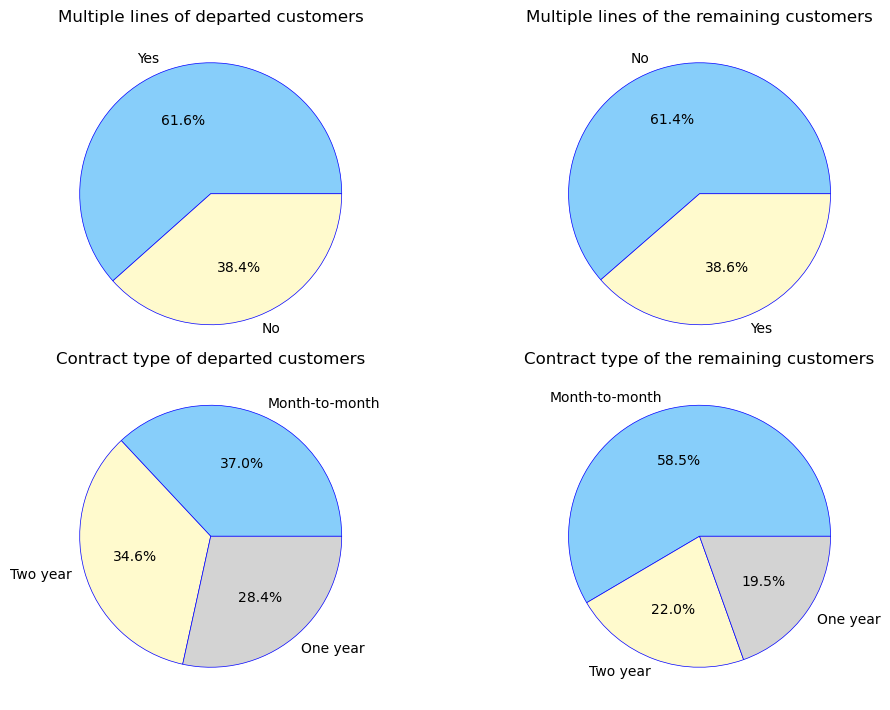

In [31]:
def visual_pie_2(df, column, index_x, index_y):
    df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[index_x, index_y],
                                                 colors=['#87CEFA', '#FFFACD', 'lightgray'],
                                                 wedgeprops={'edgecolor': 'blue', 'linewidth': 0.5})
    axes[index_x, index_y].axis('off')
    plt.tight_layout()
    
fig, axes = plt.subplots(2, 2, figsize=(14, 7))
plt.subplots_adjust(hspace=0.2)

visual_pie_2(data_left, 'multiple_lines', 0, 0)
visual_pie_2(data_stay, 'multiple_lines', 0, 1)
visual_pie_2(data_left, 'type', 1, 0)
visual_pie_2(data_stay, 'type', 1, 1)

axes[0,0].set_title('Multiple lines of departed customers')
axes[0,1].set_title('Multiple lines of the remaining customers')
axes[1,0].set_title('Contract type of departed customers')
axes[1,1].set_title('Contract type of the remaining customers');

The clients who left also mostly used multiple lines, and the remaining clients mostly do not use this service, also the clients who left more often chose long-term payment types, and the remaining clients paid from month to month. Let's look at the distribution of personal characteristics of customers:

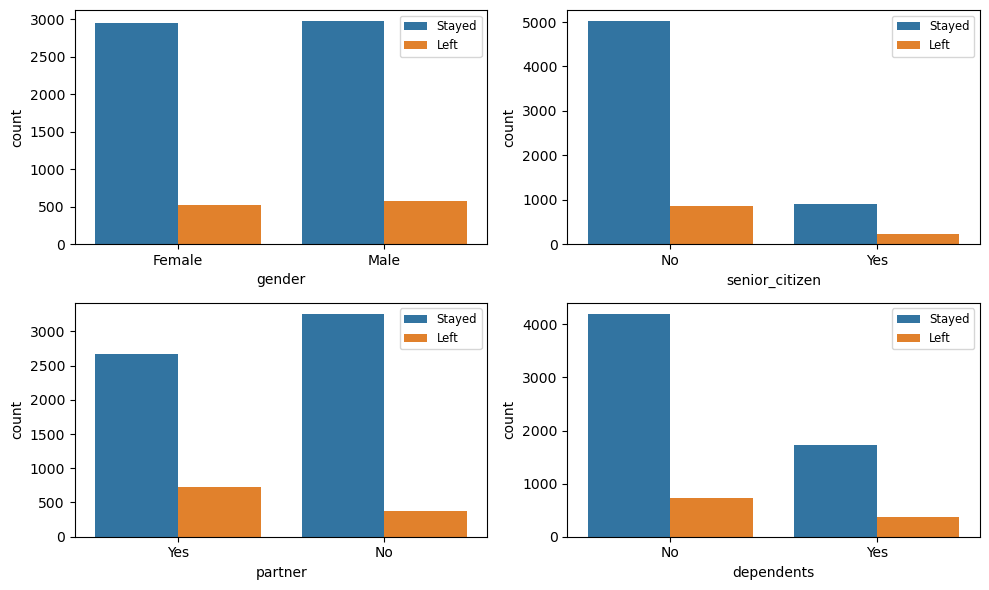

In [32]:
def visual_column(column, index_x, index_y):
    sns.countplot(x=column, hue='left_the_company', data=data, ax=axes[index_x, index_y])
    plt.tight_layout()
    axes[index_x, index_y].legend(['Stayed', 'Left'], fontsize='small')
    
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
visual_column('gender', 0, 0)
visual_column('senior_citizen', 0, 1)
visual_column('partner', 1, 0)
visual_column('dependents', 1, 1)

Based on the graphs, we can conclude that gender, having dependents and being a pensioner do not affect leaving the company, while clients without a partner were more likely to stay with the company and less likely to leave. On the basis of the analysis let's remove the features that will not affect the quality of the model - these are `begin_date` and `end_date` because instead of them we have added the feature `days_at_company` and personal data equally affect the fact of leaving `gender`, `senior_citizen` and `dependents`. Let's build a correlation matrix of all the features in order to remove unnecessary ones and look at the dependencies:

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'left_the_company', 'days_at_company']


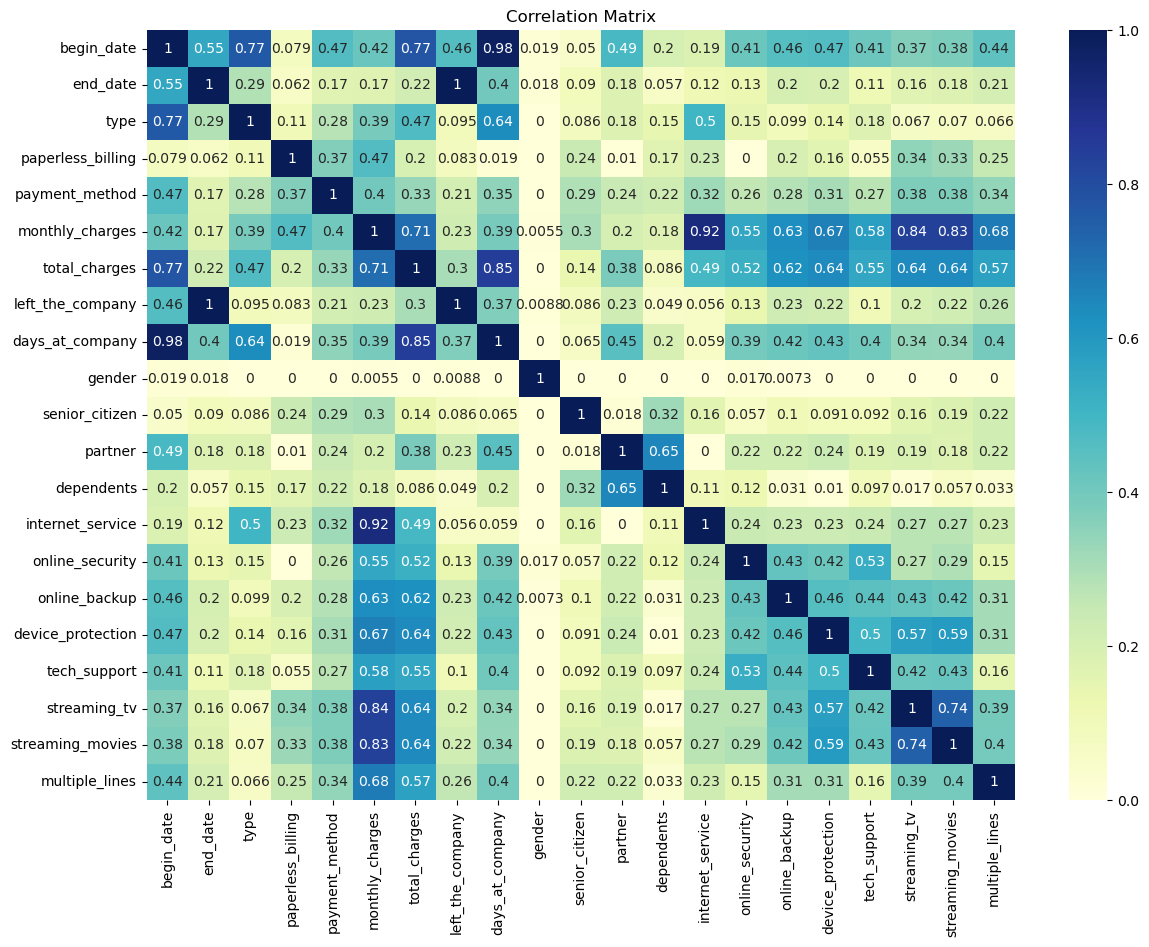

In [33]:
phik_matrix_data = data.phik_matrix()
plt.figure(figsize=(14, 10))
sns.heatmap(phik_matrix_data, annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

Let's get rid of unimportant features (weakly correlated with the target) and display the dataframe after all the changes:

In [34]:
data.drop(['begin_date', 'end_date', 'gender', 'senior_citizen', 'dependents'], axis=1, inplace=True)
data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,left_the_company,days_at_company,partner,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0.0,31,Yes,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0.0,1036,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0.0,123,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0.0,1371,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0.0,153,No,Fiber optic,No,No,No,No,No,No,No


**Conclusion:**
- we imported necessary libraries and preprocessed data (converted data types, checked them for duplicates, eliminated missing values, reduced feature names to 'snake_case', merged all the dataframes into one)
- did exploratory data analysis and found out that 15.7% of the clients had left the company
- drew charts of client churn and a correlation matrix of numerical features that showed that the client's leaving the company was most dependent on the monthly payment
- on the average, the clients who left the company paid more per month than the remaining clients, the amount of payments of the clients who left the company is on the average much more than the remaining clients, as well as the minimum amount of payments of the users who left the company is 3 times more than the amount of the remaining clients. By the length of stay in the company, the clients who left the company were the clients of the company longer.
- half of the clients who left the company had been connected to additional Internet services, which explains higher monthly payments and total amount of payments
- we compared the use of multiple lines communication and the types of payments by the remaining users and those who left and found out that the leaving customers mostly used multiple lines services, while the remaining ones mostly don't use this service, also the leaving customers more often chose the long-term payment types, while the remaining ones paid from month to month
- plotted personal data and concluded that gender, having dependents and being a pensioner did not affect leaving the company, while clients without a partner were more likely to stay and less likely to leave
- got rid of unnecessary features

# Model selection and training

## Data preparation

Examine the class imbalance of the target feature `left_the_company`:

In [35]:
data['left_the_company'].value_counts(normalize=True) * 100

0.0    84.343003
1.0    15.656997
Name: left_the_company, dtype: float64

We see that 16% of clients left the company, the classes are not balanced, but our metric is not sensitive to imbalance, so we will not balance the data.

We save the features and the target feature in the `features` and `target` variables and divide the sample into training and test samples at a ratio of 3:1:

In [36]:
features = data.drop('left_the_company',axis=1)
target = data['left_the_company']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.25,
                                                                            random_state=RANDOM_STATE)
print(f'Training sample size: {len (features_train) / len(data):.0%}')
print(f'Test sample size: {len (features_test) / len(data):.0%}')

Training sample size: 75%
Test sample size: 25%


Convert the categorical features using the One-Hot Encoding (OHE) method, write the categorical and numerical features to the `categorical` and `numeric` variables, and apply scaling using the StandardScaler method to the numerical features:

In [37]:
numeric = features_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
categorical = features_train.select_dtypes(include='object').columns.to_list()

print('Numeric features:', numeric, '\n')
print('Categorical features:', categorical)

Numeric features: ['monthly_charges', 'total_charges', 'days_at_company'] 

Categorical features: ['type', 'paperless_billing', 'payment_method', 'partner', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


In [38]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[categorical])

features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[categorical])

features_train = features_train.drop(categorical, axis=1)
scaler = StandardScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_train.head()

,monthly_charges,total_charges,days_at_company,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,partner_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
customer_id,,,,,,,,,,,,,,,,,,,
2133-TSRRM,1.340745,0.708307,0.184013,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
8859-AXJZP,-1.370670,-0.557559,0.405027,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2799-ARNLO,0.143799,-0.848845,-1.108404,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8017-LXHFA,0.988311,0.058688,-0.263869,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
9720-JJJOR,-0.157100,0.152066,0.494311,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


The training sample is coded, let's move on to the test sample:

In [39]:
features_test[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_test[categorical])
features_test = features_test.drop(categorical, axis=1)
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

C:\Users\Julia\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,monthly_charges,total_charges,days_at_company,x0_One year,x0_Two year,x1_Yes,x2_Credit card (automatic),x2_Electronic check,x2_Mailed check,x3_Yes,x4_Fiber optic,x4_No,x5_Yes,x6_Yes,x7_Yes,x8_Yes,x9_Yes,x10_Yes,x11_Yes
customer_id,,,,,,,,,,,,,,,,,,,
5025-GOOKI,-1.533588,-0.834129,-0.439509,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1110-KYLGQ,1.437165,2.359831,1.474967,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
6723-WSNTY,1.432178,2.683486,1.609624,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
9548-LERKT,-1.505327,-0.784459,-0.263869,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0303-UNCIP,-0.000832,0.242808,0.494311,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [40]:
features_train.shape, features_test.shape

((5274, 19), (1758, 19))

We have divided the samples, coded the data and scaled the numerical features, and now choose a model for further testing. We start with the random forest model:

### Random Forest Classifier
We will train and estimate the random forest model on cross-validation, select hyperparameters using `RandomizedSearchCV`, and estimate quality with the `AUC-ROC` and `Accuracy` metrics:

In [41]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

params = {'n_estimators': range(500, 2000, 100),
          'max_depth': range(5, 25),
          'criterion': ['gini', 'entropy'],
          'min_samples_split': range(2, 20),
          'max_features': ['auto', 'sqrt', 'log2']}

search_model_rf = RandomizedSearchCV(model_rf, params, cv=5, n_jobs=-1, verbose=3)
search_model_rf.fit(features_train, target_train)
best_model_rf = search_model_rf.best_estimator_

roc_rf = cross_val_score(best_model_rf, features_train, target_train, scoring = 'roc_auc', cv = 5, n_jobs = -1)
accuracy_rf = cross_val_score(best_model_rf, features_train, target_train, scoring = 'accuracy', cv = 5, n_jobs = -1)

print('Best params:', search_model_rf.best_params_)
print('AUC-ROC Random Forest Classifier:', roc_rf.mean())
print('Accuracy Random Forest Classifier:', accuracy_rf.mean())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'n_estimators': 800, 'min_samples_split': 9, 'max_features': 'sqrt', 'max_depth': 23, 'criterion': 'gini'}
AUC-ROC Random Forest Classifier: 0.8163469445390102
Accuracy Random Forest Classifier: 0.8577923864852469


Using RandomizedSearchCV, we selected hyperparameters such as number of estimators, max depth, criterion, minimum samples split, and max features. The AUC-ROC of the model on the cross-validation sample is below the target threshold (0.816), accuracy is slightly higher (0.857). Moving on to the Cat Boost model:

### Cat Boost Classifier
We will train and estimate the Cat Boost model on cross-validation, select hyperparameters using `RandomizedSearchCV`, and estimate quality with the `AUC-ROC` and `Accuracy` metrics:

In [42]:
model_cb = CatBoostClassifier(loss_function='Logloss', random_seed=RANDOM_STATE, silent=True)

catboost_params = {'depth': range(1, 12),
                   'iterations': range(500, 2001, 500),
                   'learning_rate': [0.5, 0.6, 0.7],
                   'l2_leaf_reg': range(1, 7)}

search_model_cb = RandomizedSearchCV(model_cb, catboost_params, cv=5, n_jobs=-1, verbose=3)
search_model_cb.fit(features_train, target_train)
best_model_cb = search_model_cb.best_estimator_

roc_cb = cross_val_score(best_model_cb, features_train, target_train, scoring = 'roc_auc', cv = 5, n_jobs = -1)
accuracy_cb = cross_val_score(best_model_cb, features_train, target_train, scoring = 'accuracy', cv = 5, n_jobs = -1)

print('Best params:', search_model_cb.best_params_)
print('AUC-ROC Cat Boost Classifier:', roc_cb.mean())
print('Accuracy Cat Boost Classifier:', accuracy_cb.mean())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'learning_rate': 0.5, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 3}
AUC-ROC Cat Boost Classifier: 0.9150457017998146
Accuracy Cat Boost Classifier: 0.9196039461496264


Using RandomizedSearchCV, we selected hyperparameters such as depth, iterations, learning rate and regularization factor. The Cat Boost model showed high values of metrics AUC-ROC (0.920) and accuracy (0.929), but the learning rate of the model is quite low. Let's move on to the LGBM model:

### LGBM Classifier
We will train and estimate the LGBM model on cross-validation, select hyperparameters using `RandomizedSearchCV`, and estimate quality with the `AUC-ROC` and `Accuracy` metrics:

In [43]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)

lgbm_params = {'max_depth': range(1, 5),
               'n_estimators': range(500, 1500, 500),
               'learning_rate': [0.2, 0.3],
               'reg_lambda': [1, 2]}

search_model_lgbm = RandomizedSearchCV(model_lgbm, lgbm_params, cv=5, n_jobs=-1, verbose=3)
search_model_lgbm.fit(features_train, target_train)
best_model_lgbm = search_model_lgbm.best_estimator_

roc_lgbm = cross_val_score(best_model_lgbm, features_train, target_train, scoring = 'roc_auc', cv = 5, n_jobs = -1)
accuracy_lgbm = cross_val_score(best_model_lgbm, features_train, target_train, scoring = 'accuracy', cv = 5, n_jobs = -1)

print('Best params:', search_model_lgbm.best_params_)
print('AUC-ROC LGBM Classifier:', roc_lgbm.mean())
print('Accuracy LGBM Classifier:', accuracy_lgbm.mean())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'reg_lambda': 2, 'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.2}
AUC-ROC LGBM Classifier: 0.9081774725633288
Accuracy LGBM Classifier: 0.9158121172333786


Using RandomizedSearchCV, we selected hyperparameters such as number of estimators, max depth, learning rate and regularization factor. The model showed metrics results slightly lower than the CatBoost AUC-ROC (0.906) and accuracy (0.913), but this model has a very high learning rate. 

For testing, let's take LGBM Classifier, it has high speed of learning and quality of the model, the metrics AUC-ROC and accuracy are slightly lower than Cat Boost.

## Testing the LGBM Classifier model

In [44]:
predictions = best_model_lgbm.predict_proba(features_test)[:, 1]

print('AUC-ROC on the test sample:', roc_auc_score(target_test, predictions))
print('Accuracy on the test sample:', accuracy_score(target_test, best_model_lgbm.predict(features_test)))

AUC-ROC on the test sample: 0.9247458872515002
Accuracy on the test sample: 0.9306029579067122


The results on the test sample are higher than the cross-validation, AUC-ROC (0.922), accuracy (0.931), the model showed a good result that exceeds the target (0.85). Let's plot the Roc-curve and the confusion matrix for the best model:

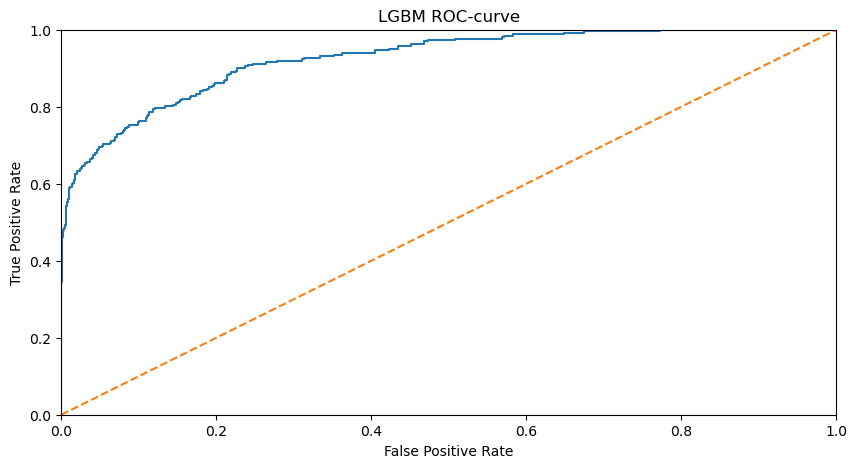

In [45]:
fpr, tpr, thresholds = roc_curve(target_test, predictions, pos_label=1)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGBM ROC-curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

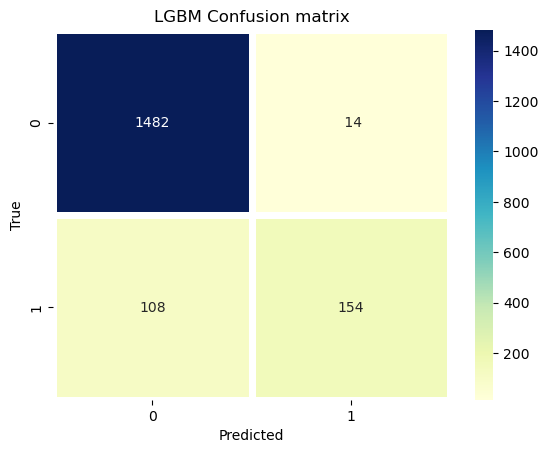

In [46]:
sns.heatmap(confusion_matrix(target_test, best_model_lgbm.predict(features_test)), annot=True, fmt='3.0f', 
            cmap='YlGnBu', linecolor='white', linewidths=5)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LGBM Confusion matrix');

The ROC-curve and confusion matrix showed that the quality of the model is high, it rarely makes mistakes and more often answers correctly.

Let's plot the importance of the features for the LGBM model:

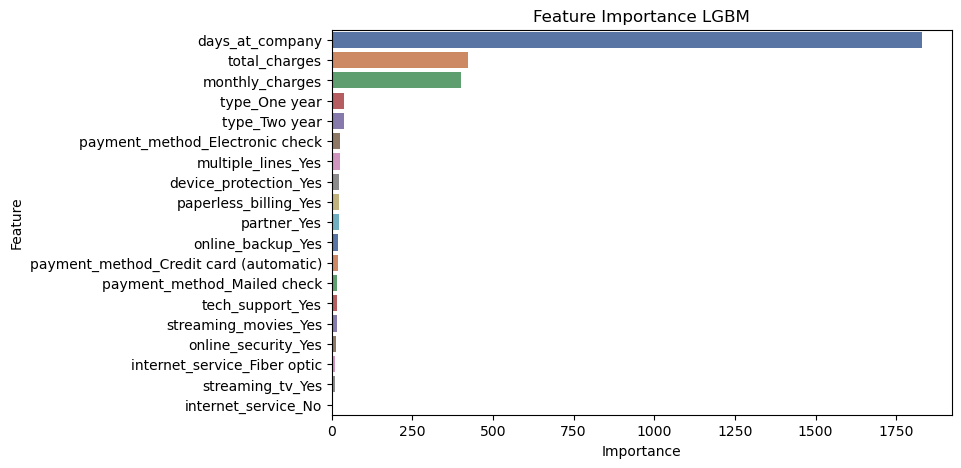

In [47]:
importance = best_model_lgbm.feature_importances_
feature_names = features_train.columns
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance, y='Feature', x='Importance', palette='deep')
plt.title('Feature Importance LGBM')
plt.show()

The most important features for the LGBM model are `days_at_company`, `total_charges`, `monthly_charges` and `type`.

**Conclusion:**
- We transformed the categorical features using One-Hot Encoding (OHE)
- We saved the features and the target feature in the 'features' and 'target' variables and divided the sample into training and test features at a ratio of 3:1
- We trained Random Forest Classifier, Cat Boost Classifier, and LGBM Classifier models on cross-validation, selected hyperparameters for them using RandomizedSearchCV, and estimated quality with AUC-ROC and Accuracy
- The worst values of metrics on cross-validation were shown by the random forest model, the best values of metrics were shown by the Cat Boost Classifier, while the LGBM Classifier is almost as good (AUC-ROC 0.907, accuracy 0.913), but learns much faster. To check it on the test sample we took the LGBM model, it showed the results on the test sample: AUC-ROC 0.923, Accuracy 0.930
- built confusion matrix, ROC-curve and importance graph for features to get more information about the model performance, found that the most important features for LGBM model are 'days_at_company', 'total_charges', 'monthly_charges' and 'type', verified the high quality of the model and that its answers are not random, the model rarely makes mistakes and often answers correctly

# Project report

1. The project was carried out without deviations from the plan: data preprocessing and analysis, categorical feature transformation by OHE and numerical scaling, partitioning into training and test samples, and training of `RandomForestClassifier`, `CatBoostClassifier` and `LGBMClassifier` models (which was tested as the best performing metric model) were carried out, ROC-AUC and additionally accuracy (accuracy not lower than 85%) were used as quality metrics, after model testing we supported calculations by visualization (ROC-curve, confusion matrix and importance of features graph for model).


2. During the work there were difficulties related to a lot of time spent on selection of hyperparameters through `GridSearch`, so it was decided to use `RandomSearch`, which significantly accelerated the process, while the quality of the models remained the same high.


3. I would like to single out preprocessing and analysis of data as the key steps of the project, as they significantly affect the quality of the future model and therefore the goal of the project: preprocessing helps to improve data quality, while analysis helps to understand which features are important for further analysis.


4. The following features were used to train the models:
    - **category:**. 
- `type`, `paperless_billing`, `payment_method`, `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, `multiple_lines`, `partner` - pre-processing of these features was not required, data are correct
    - **numeric:**
       - `monthly_charges` - did not need preprocessing (data is correct)
       - `total_charges` - on the preprocessing stage there were skips, which concerned the users connected to the tariff on the day of the database upload (2020-02-01), such values were too small (less than 1%), to replace them was not expedient and lines with missing values, we deleted and replaced the data type object on float
- `days_at_company` - is a feature that we have created, which indicates how long the client has been in the company and with it we have replaced two features - end_date and begin_date
    - **target:**
- `left_the_company` - is a feature that we created based on 'end_date' (subsequently deleted): if the date of clients departure from the company was equal to the date of uploading data, those clients were defined as remaining clients, all other clients were defined as having left the company.
     
All categorical features after preprocessing were encoded by `One-Hot encoding` method, and numerical features were scaled by `StandardScaler` method, we also studied class imbalance, but the metric by which models were estimated is not sensitive to imbalance, so it was decided to leave the data unbalanced.


5. The final model was chosen `LGBMClassifier` because it's quality was high, and it's learning rate significantly exceeded that of the other models under consideration. Hyperparameters: 'reg_lambda' = 1, 'n_estimators' = 1000, 'max_depth' = 2, 'learning_rate' = 0.3, 'random_state' = 120623. On the training sample the model showed results `AUC-ROC = 0.9057` and `Accuracy = 0.9182`, on the test sample `AUC-ROC 0.9240`, `Accuracy 0.9334`.